In this file I will be building and evaluating my model, based on the data made with the other jupyter notebooks.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('NS_Data\combined_trein_data_feature_engineered.csv')
len(df)


<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\bramm\AppData\Local\Temp\ipykernel_19616\1223601378.py:1: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_csv('NS_Data\combined_trein_data_feature_engineered.csv')


1000000

In [3]:
df.head()

,Service:RDT-ID,Service:Completely cancelled,Service:Partly cancelled,Stop:Departure delay,Stop:Platform change,departure datetime,departure year,departure month,departure day,departure hour,...,Service:Company_Blauwnet,Service:Company_Breng,Service:Company_DB,Service:Company_Eurobahn,Service:Company_NMBS,Service:Company_NS,Service:Company_R-net,Service:Company_Railexpert,Service:Company_Valleilijn,station_encoded
0,738804,False,False,1.0,True,2019-01-01 01:00:00+00:00,2019.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,287
1,738804,False,False,0.0,False,2019-01-01 01:12:00+00:00,2019.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,89
2,738804,False,False,1.0,False,2019-01-01 01:21:00+00:00,2019.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,95
3,738804,False,False,0.0,False,2019-01-01 01:45:00+00:00,2019.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,225
4,738804,False,False,0.0,False,2019-01-01 02:02:00+00:00,2019.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,302


### LAG

In [15]:
df["departure datetime"] = pd.to_datetime(df["departure datetime"])
df["departure datetime"] = df["departure datetime"].fillna(0)
df["departure datetime"].isna().sum()

ValueError: Cannot mix tz-aware with tz-naive values

In [16]:
df = df.sort_values(["station_encoded", "departure datetime"])

df["station_delay_lag_30m"] = (
    df
    .groupby("station_encoded")
    .rolling("30min", on="departure datetime")["Stop:Departure delay"]
    .median()
    .shift(1)
    .reset_index(level=0, drop=True)
)
df.head()

TypeError: 'values' is not ordered, please explicitly specify the categories order by passing in a categories argument.

### Delay bins

In [3]:
def delay_to_bin(delay):
    if delay < 3:
        return 0
    elif delay < 10:
        return 1
    elif delay < 30:
        return 2
    else:
        return 3
    
df['delay_bin'] = df['Stop:Departure delay'].apply(delay_to_bin)

<Axes: xlabel='delay_bin'>

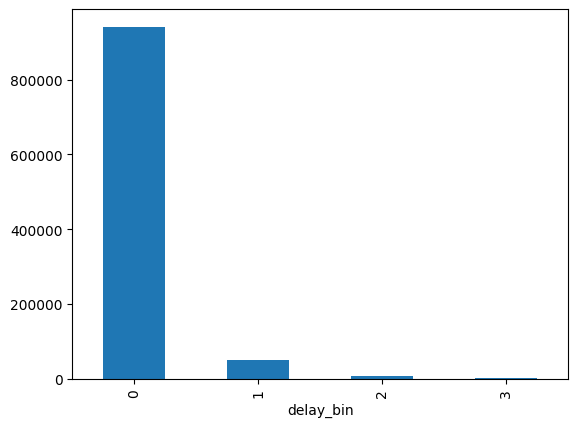

In [4]:
df['delay_bin'].value_counts().sort_index().plot(kind='bar')

Target:
Stop:Departure delay — a continuous value (so it’s a regression problem).

Goal:
Predict future delay given time, station, service type, etc.

Important: Because it’s time-dependent, always split data chronologically, not randomly — you want the model to learn from past → predict future.

For now I want to create a solid baseline, in this baseline I will be using a normal random train, test split not based on chronological order and a simple Tree based regression.

For now a fixed date cutoff is the best approach, this splits the data at a certain percentile, for exmaple the first 80% as train and the next 20% as test data.

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# X = df.drop("Stop:Departure delay", axis=1)
# y = df["Stop:Departure delay"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_frac, val_frac = 0.7, 0.15
n = len(df)
train_df = df.iloc[:int(n*train_frac)]
val_df = df.iloc[:int(n * train_frac):int(n * (train_frac + val_frac))]
test_df = df.iloc[:int(n * (train_frac + val_frac))]



In [6]:
rng = np.random.default_rng(42)

def undersample(df, max_per_bin):
    parts = []
    for bin_id, max_n in enumerate(max_per_bin):
        subset = df[df['delay_bin'] == bin_id]
        if max_n is None or len(subset) <= max_n:
            parts.append(subset)
        else:
            parts.append(subset.sample(n=max_n, random_state=rng))
    return pd.concat(parts)

max_samples_per_bin = [50_000, 50_000, None, None, None]

train_df_balanced = undersample(train_df, max_samples_per_bin)

In [7]:
def delay_weight(delay):
    if delay <= 3:
        return 1
    elif delay <= 10:
        return 2
    elif delay <= 30:
        return 5
    else:
        return 15

train_df_balanced["sample_weight"] = (
    train_df_balanced["Stop:Departure delay"].apply(delay_weight)
)

In [8]:
target = "Stop:Departure delay"
train_drop_cols = ["Stop:Departure delay", "delay_bin", "sample_weight"]
eval_drop_cols  = ["Stop:Departure delay", "delay_bin"]

X_train = train_df_balanced.drop(columns=train_drop_cols)
y_train = train_df_balanced[target]
w_train = train_df_balanced["sample_weight"]

X_val = val_df.drop(columns=eval_drop_cols)
y_val = val_df[target]

X_test = test_df.drop(columns=eval_drop_cols)
y_test = test_df[target]

In [9]:
model = RandomForestRegressor(n_estimators=500,
                              max_depth=20,
                              min_samples_leaf=5,
                              random_state=42,
                              n_jobs=-1)

model.fit(X_train, y_train, sample_weight=w_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)

test_df = test_df.copy()
test_df["pred"] = y_pred
test_df["abs_error"] = (test_df["pred"] - test_df["Stop:Departure delay"]).abs()
# Overall MAE
print("Overall MAE:", mean_absolute_error(y_test, y_pred))

# MAE per delay bin
for bin_id, name in {
    0: "0–3",
    1: "3–10",
    2: "10–30",
    3: "30+"
}.items():
    subset = test_df[test_df["delay_bin"] == bin_id]
    if len(subset) > 0:
        print(
            f"MAE {name} min:",
            subset["abs_error"].mean()
        )

Overall MAE: 3.2367269341187037
MAE 0–3 min: 3.242247710454822
MAE 3–10 min: 2.292739209954257
MAE 10–30 min: 7.007416147867127
MAE 30+ min: 20.82685900697466


Input features → predicted delay

So when predicting a new train, you must give it the same columns you used during training:
- Service:Completely cancelled
- Service:Partly cancelled  
- departure year 
- departure month 
- departure day
- departure hour
- departure minute 
- departure weekday 
- season 
- Service:Type_Alpen Express 
- Service:Type_Bus
- Service:Type_Eurostar 
- Service:Type_Extra trein
- Service:Type_ICE International
- Service:Type_Int. Trein
- Service:Type_Intercity
- Service:Type_Intercity direct
- Service:Type_RE 19
- Service:Type_Snelbus i.p.v. trein
- Service:Type_Sneltrein
- Service:Type_Speciale Trein
- Service:Type_Sprinter 
- Service:Type_Stopbus i.p.v. trein
- Service:Type_Stoptrein
- Service:Type_Thalys
- Service:Type_stoptrein
- Service:Company_ABRN 
- Service:Company_Abellio Ra
- Service:Company_Arriva
- Service:Company_Blauwnet,Service:Company_Breng
- Service:Company_DB,Service:Company_Eurobahn
- Service:Company_NMBS 
- Service:Company_NS,Service:Company_R-net
- Service:Company_Railexpert 
- Service:Company_Valleilijn 
- station_encoded

In [11]:
new_train = {
    # Cancellation flags
    "Service:Completely cancelled": False,
    "Service:Partly cancelled": False,

    # Temporal features
    "departure year": 2026,
    "departure month": 1,
    "departure day": 4,
    "departure hour": 8,
    "departure minute": 30,
    "departure weekday": 1,
    "season": 4,

    # Service type one-hot features
    "Service:Type_Alpen Express": 0,
    "Service:Type_Bus": 0,
    "Service:Type_Eurostar": 0,
    "Service:Type_Extra trein": 0,
    "Service:Type_ICE International": 0,
    "Service:Type_Int. Trein": 0,
    "Service:Type_Intercity": 1,
    "Service:Type_Intercity direct": 0,
    "Service:Type_RE 19": 0,
    "Service:Type_Snelbus i.p.v. trein": 0,
    "Service:Type_Sneltrein": 0,
    "Service:Type_Speciale Trein": 0,
    "Service:Type_Sprinter": 0,
    "Service:Type_Stopbus i.p.v. trein": 0,
    "Service:Type_Stoptrein": 0,
    "Service:Type_Thalys": 0,
    "Service:Type_stoptrein": 0,

    # Company one-hot features
    "Service:Company_ABRN": 0,
    "Service:Company_Abellio Ra": 0,
    "Service:Company_Arriva": 0,
    "Service:Company_Blauwnet": 0,
    "Service:Company_Breng": 0,
    "Service:Company_DB": 0,
    "Service:Company_Eurobahn": 0,
    "Service:Company_NMBS": 0,
    "Service:Company_NS": 1,
    "Service:Company_R-net": 0,
    "Service:Company_Railexpert": 0,
    "Service:Company_Valleilijn": 0,

    # Encoded station
    "station_encoded": 287
}


In [12]:
new_df = pd.DataFrame([new_train])
new_pred = model.predict(new_df)
print(f"Predicted Departure Delay for new data: {new_pred[0]:.2f} minutes, or {new_pred[0]*60:.2f} seconds")

Predicted Departure Delay for new data: 5.55 minutes, or 332.94 seconds
